<a href="https://colab.research.google.com/github/paras953/stock_market_prediction_technicals/blob/main/Technical_model_git_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#The cell below connects google colab to your google drive

In [ ]:
#for experiment purposes lets try removing the missing values----does not work

In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive

In [227]:
#all necessary libs
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import os
from matplotlib.backends.backend_pdf import PdfPages
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,plot_roc_curve,roc_curve,auc
from sklearn.preprocessing import MultiLabelBinarizer
from scipy import stats
import pylab
from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import chisquare
from scipy.stats import f_oneway
import itertools
from sklearn.metrics import jaccard_score
from sklearn.ensemble import RandomForestClassifier


#neural net
import keras
from keras.layers import Dense,Input
from keras.models import Model

#xgboost
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
# from xgboost.sklearn import XGBClassifier
# #from sklearn import cross_validation, metrics   #Additional scklearn functions
# from sklearn.grid_search import GridSearchCV   #Perforing grid search

In [228]:
#For all types of data

def read_df(path,file_type):
  df=pd.read_csv(path)
  df['FILE_TYPE']=file_type
  return df


#use only when palnning to merge everyting
def drop_cols(df):
  df=df.drop(columns=['Sub-Sector','Name','Close Price','Market Cap'])
  return df


def filter_df(df):
  df=df.dropna(subset=['Market Cap','Close Price','PE Ratio'],how='any')
  mask=(df['Market Cap']>0) #try with midcaps
  df=df[mask]
  mask=(df['Close Price']>0)
  df=df[mask]
  mask=((df['Sub-Sector']!='Equity') &(df['Sub-Sector']!='Gold') & (df['Sub-Sector']!='Debt'))
  df=df[mask]
  mask=(df['Ticker']!='RELIANCEP1') #partly paid remove
  df=df.drop_duplicates(subset=['Ticker'],keep=False) #some duplicates ...dropping those all together
  print('Dropped duplicates')
  return df

In [229]:
###Starts here 
#only for technicals

def read_technical_df(t,t_minus_1,t_plus_1):

  time_dict={'t':t,'t_minus_1':t_minus_1,'t_plus_1':t_plus_1}
  key_t='t'
  key_t_minus_1='t_minus_1'
  key_t_plus_1='t_plus_1'

  root_path='drive/ticker_tape_data/'
  
  print(f'{root_path}Technicals_only_{time_dict[key_t]}.csv')
  print(f'{root_path}Technicals_only_{time_dict[key_t_minus_1]}.csv')

  df_t=filter_df(read_df(f'{root_path}Technicals_only_{time_dict[key_t]}.csv',file_type='TECHN'))
  df_t_minus_1=filter_df(read_df(f'{root_path}Technicals_only_{time_dict[key_t_minus_1]}.csv',file_type='TECHN'))
  df_t_plus_1=filter_df(read_df(f'{root_path}Technicals_only_{time_dict[key_t_plus_1]}.csv',file_type='TECHN'))

  rename_t_plus_1={}

  for columns in df_t_plus_1.columns:
    rename_t_plus_1[columns]=columns+'_'+'t_plus_1'

  df_t_plus_1.rename(columns=rename_t_plus_1,inplace=True)


  return df_t,df_t_minus_1,df_t_plus_1,rename_t_plus_1
 

def get_edd(df):

  summary=df.describe(include='all')
  summary.loc['dtype'] = df.dtypes
  summary.loc['size'] = len(df)
  summary.loc['missing_rate'] = df.isnull().mean()*100
  summary.loc['missing_count'] = df.isnull().sum()
  summary.loc['fill_rate']=(1-df.isnull().mean())*100
  summary.fillna('NA',inplace=True)
  return summary.T


def process_technicals(df):

  

  dict_fill={'% Price above 1M SMA':0,'% Price above 1M EMA':0,'RSI Exponential – 14D':50,'RSI – 14D':50}
  dict_fill['MACD Line 1 – Trend Indicator']=0
  dict_fill['MACD Line 2 – Signal Line Comp']=0
  dict_fill['1W Change in On Balance Volume']=0
  dict_fill['Relative Volume']=1
  dict_fill['Volatility']=0
  dict_fill['Volatility vs Nifty']=0
  dict_fill['1W Change in AD Line']=0
  dict_fill['% Price above 1Y SMA']=0
  dict_fill['Sharpe Ratio']=0
  dict_fill['% From Parabolic SAR']=0
  dict_fill['ADX Rating – Trend Strength']=0
  dict_fill['% From Lower Bollinger Band']=0
  dict_fill['% From Upper Bollinger Band']=0
  dict_fill['Stochastic %K']=50
  dict_fill['Stochastic %D']=50
  dict_fill['William %R']=-50
  
  #drop nas
  #columns_to_drop=list(dict_fill.keys())
  #df.dropna(subset=columns_to_drop,inplace=True)
  df=df.fillna(dict_fill)
  
  df['%K/%D']=df['Stochastic %K']/df['Stochastic %D']  
  df['10d/50d_SMA']=df['10D SMA']/df['50D SMA']
  df['50d/100d_SMA']=df['50D SMA']/df['100D SMA']
  df['100d/200d_SMA']=df['100D SMA']/df['200D SMA'] 
  df['10d/50d_EMA']=df['10D EMA']/df['50D EMA']
  df['50d/100d_EMA']=df['50D EMA']/df['100D EMA']
  df['100d/200d_EMA']=df['100D EMA']/df['200D EMA']
  df['Close Price/10d_ema']=df['Close Price']/df['10D EMA']
  df['Close Price/10d_sma']=df['Close Price']/df['10D SMA']
  df['super_trend/close_price']=df['Super Trend']/df['Close Price'] 
  df['vwap/close_price']=df['VWAP']/df['Close Price']

  dict_avg={} #filling all the nulls with one
  dict_avg['10d/50d_SMA']=1
  dict_avg['50d/100d_SMA']=1
  dict_avg['100d/200d_SMA']=1
  dict_avg['10d/50d_EMA']=1
  dict_avg['50d/100d_EMA']=1
  dict_avg['100d/200d_EMA']=1
  dict_avg['Close Price/10d_ema']=1
  dict_avg['Close Price/10d_sma']=1
  dict_avg['%K/%D']=1  
  dict_avg['vwap/close_price']=1
  dict_avg['super_trend/close_price']=1
  df=df.fillna(dict_avg)

  mask_strong_up=((df['MACD Line 2 – Signal Line Comp']>0) & (df['MACD Line 1 – Trend Indicator']>0))
  mask_weak_up=((df['MACD Line 2 – Signal Line Comp']<=0) & (df['MACD Line 1 – Trend Indicator']>0))
  mask_strong_down=((df['MACD Line 2 – Signal Line Comp']<=0) & (df['MACD Line 1 – Trend Indicator']<=0))
  mask_weak_down=((df['MACD Line 2 – Signal Line Comp']>0) & (df['MACD Line 1 – Trend Indicator']<=0))

  
  # df.loc[mask_strong_up,'MACD_current_indicator']='STRONG_UP'
  # df.loc[mask_weak_up,'MACD_current_indicator']='WEAK_UP'
  # df.loc[mask_strong_down,'MACD_current_indicator']='STRONG_DOWN'
  # df.loc[mask_weak_down,'MACD_current_indicator']='WEAK_DOWN'

  #Trying to binary encode MACD indicator
  df['MACD_WEAK_STRONG_flag']=0
  df.loc[mask_strong_up,'MACD_WEAK_STRONG_flag']=1
  df.loc[mask_strong_down,'MACD_WEAK_STRONG_flag']=1

  df['MACD_UP_DOWN_flag']=0 #0 means down
  df.loc[mask_strong_up,'MACD_UP_DOWN_flag']=1
  df.loc[mask_weak_up,'MACD_UP_DOWN_flag']=1
  #for explanation purposes STRONG_UP will have both variables as 1
  
  range_positive=[-np.inf,20,50,80,np.inf]
  range_negative=[-np.inf,-80,-50,-20,np.inf]

  final_column_list=['MACD_UP_DOWN_flag','MACD_WEAK_STRONG_flag']
  demand_indicators=['RSI Exponential – 14D','RSI – 14D','Stochastic %D','Stochastic %K','William %R','ADX Rating – Trend Strength']
  
  for items in demand_indicators:

    if items=='William %R':
      print('William so neg range')
      range_list=range_negative
    else:
      range_list=range_positive
    
    df=create_demand_flags(df,col_name=items,range_list=range_list)
    final_column_list.append(items+'_demand_flag1')
    final_column_list.append(items+'_demand_flag2')

  for keys in dict_avg.keys():
    df=create_ratio_flags(df,col_name=keys)
    final_column_list.append(keys+'_flag')

  for keys in dict_fill.keys():
    final_column_list.append(keys)
    
  return df,final_column_list


def create_demand_flags(df,col_name,range_list):
  labels=['oversold','sold','bought','overbought']
  df[col_name+'_demand']=pd.cut(df[col_name],bins=range_list,labels=labels,right=True)

  mask_bought=(df[col_name+'_demand']=='bought')
  mask_over_bought=(df[col_name+'_demand']=='overbought')
  mask_sold=(df[col_name+'_demand']=='sold')
  mask_over_sold=(df[col_name+'_demand']=='oversold')

  df[col_name+'_demand_flag1']=0
  df.loc[mask_bought,col_name+'_demand_flag1']=1
  df.loc[mask_over_bought,col_name+'_demand_flag1']=1

  df[col_name+'_demand_flag2']=0
  df.loc[mask_over_sold,col_name+'_demand_flag2']=1
  df.loc[mask_over_bought,col_name+'_demand_flag2']=1

  
  print(col_name)
  print( 'flag1 ',df[col_name+'_demand_flag1'].unique())
  print('flag2 ',df[col_name+'_demand_flag2'].unique())
  df[[col_name+'_demand',col_name,'Ticker',col_name+'_demand_flag1',col_name+'_demand_flag2']].to_csv(col_name+'.csv')
  df.drop(columns=[col_name+'_demand'],inplace=True)
  return df
  


def create_ratio_flags(df,col_name):
  #if the said ratio>=1 then 1 else 0
  mask=(df[col_name]>=1)
  df[col_name+'_flag']=0
  df.loc[mask,col_name+'_flag']=1
  return df

def interday_technicals(df_t,df_t_minus_1,t,t_minus_1):

  #t : date of current day
  #t_minus_1 : date of previous day
  rename_t={}
  rename_t_minus_1={}
  for cols in df_t.columns:
    rename_t[cols]=cols+'_'+t
    rename_t_minus_1[cols]=cols+'_'+t_minus_1

  print('About to rename columns')
  df_t.rename(columns=rename_t,inplace=True)
  df_t_minus_1.rename(columns=rename_t_minus_1,inplace=True)

  final_merge=df_t.merge(df_t_minus_1,left_on=rename_t['Ticker'],right_on=rename_t_minus_1['Ticker'],how='inner')
  final_merge=create_trigger(final_merge,rename_t_minus_1,rename_t,col_name='MACD Line 2 – Signal Line Comp')
  final_merge=create_trigger(final_merge,rename_t_minus_1,rename_t,col_name='MACD Line 1 – Trend Indicator')

  #make one ADX variable ie ADX-25
  final_merge['ADX_above_25_'+t]=final_merge[rename_t['ADX Rating – Trend Strength']]-25
  final_merge['ADX_above_25_'+t_minus_1]=final_merge[rename_t_minus_1['ADX Rating – Trend Strength']]-25
  
  #New entries in rename_t and rename_t_minus_1
  rename_t['ADX_above_25']='ADX_above_25_'+t
  rename_t_minus_1['ADX_above_25']='ADX_above_25_'+t_minus_1

  final_merge=create_trigger(final_merge,rename_t_minus_1,rename_t,col_name='ADX_above_25')


  #SAR trigger 
  final_merge=create_trigger(final_merge,rename_t_minus_1,rename_t,col_name='% From Parabolic SAR')
  
  #William R trigger
  final_merge['Williamson_R_above_50_'+t]=final_merge[rename_t['William %R']]+50
  final_merge['Williamson_R_above_50_'+t_minus_1]=final_merge[rename_t_minus_1['William %R']]+50
  #New entries in rename_t and rename_t_minus_1
  rename_t['Williamson_R_above_50']='Williamson_R_above_50_'+t
  rename_t_minus_1['Williamson_R_above_50']='Williamson_R_above_50_'+t_minus_1

  final_merge=create_trigger(final_merge,rename_t_minus_1,rename_t,col_name='% From Upper Bollinger Band')
  final_merge=create_trigger(final_merge,rename_t_minus_1,rename_t,col_name='% From Lower Bollinger Band')
  return final_merge,rename_t,rename_t_minus_1



def difference_KPI(final_merge,rename_t_minus_1,rename_t,col_name):
  final_merge[col_name+'_interday_difference']=final_merge[rename_t[col_name]]-final_merge[rename_t_minus_1[col_name]]
  return final_merge



def create_trigger(final_merge,rename_t_minus_1,rename_t,col_name,col_type='continuous'):

  final_merge[col_name+'_interday_trigger_1']=0
  final_merge[col_name+'_interday_trigger_2']=0

  # if col_type=='flag': ----> Completely redundant
  #   final_merge.drop(columns=[col_name+'_interday_trigger_2'],inplace=True) #no use here  
  #   mask_10=((final_merge[rename_t_minus_1[col_name]]==1) & (final_merge[rename_t[col_name]])==0)
  #   mask_01=((final_merge[rename_t_minus_1[col_name]]==0) & (final_merge[rename_t[col_name]])==1)
  #   mask_11=((final_merge[rename_t_minus_1[col_name]]==1) & (final_merge[rename_t[col_name]])==1)
  #   mask_00=((final_merge[rename_t_minus_1[col_name]]==0) & (final_merge[rename_t[col_name]])==0)
    
  #   mask_dict={'1_0':mask_10,'0_1':mask_01,'0_0':mask_00,'1_1':mask_11}

  #   for keys in mask_dict.keys():
  #     if keys.split('_')[0]!=keys.split('_')[1]:
  #       #trig_1=int(keys.split('_')[0])
  #       trig_1=1
  #       #trig_2=int(keys.split('_')[1])
  #     else:
  #       trig_1=0
  #       #trig_2=0
      
  #     final_merge.loc[mask_dict[keys],col_name+'_interday_trigger_1']=trig_1
  #     #final_merge.loc[mask_dict[keys],col_name+'_interday_trigger_2']=trig_2

  #   return final_merge

  #fill nas with 0---which means no trigger
  mask_pos_neg=((final_merge[rename_t_minus_1[col_name]]>0) & (final_merge[rename_t[col_name]]<=0))
  mask_neg_pos=((final_merge[rename_t_minus_1[col_name]]<0) & (final_merge[rename_t[col_name]]>=0))
  mask_pos_pos=((final_merge[rename_t_minus_1[col_name]]>=0) & (final_merge[rename_t[col_name]]>=0))
  mask_neg_neg=((final_merge[rename_t_minus_1[col_name]]<=0) & (final_merge[rename_t[col_name]]<=0))  

  mask_dict={'1_0':mask_pos_neg,'0_1':mask_neg_pos,'0_0':mask_neg_neg,'1_1':mask_pos_pos}

  for keys in mask_dict.keys():
    final_merge.loc[mask_dict[keys],col_name+'_interday_trigger_1']=int(keys.split('_')[0])
    final_merge.loc[mask_dict[keys],col_name+'_interday_trigger_2']=int(keys.split('_')[1])
  
  print(col_name,final_merge[col_name+'_interday_trigger_1'].isna().sum())
  print(col_name,final_merge[col_name+'_interday_trigger_2'].isna().sum())
  #Fill nas in trigger flags ...fill it as 0s

  dict_fill={col_name+'_interday_trigger_1':0,col_name+'_interday_trigger_2':0}
  final_merge.fillna(dict_fill,inplace=True)  
  return final_merge

In [242]:
model_name='logit' # one of random_forest, neural_net, logit and xgboost

t_minus_1='9_29_2021'
t='9_30_2021'
t_plus_1='10_1_2021'
gain_perc=0.02 #any stock having gain above this value will be considered as 1

if model_name in ['logit','neural_net','xgboost']:
  #trying for xgbooost too since normalization gave good results on test set
  norm=True #if true then normalize else dont
else:
  #no need for tree based learners
  norm=False

df_t,df_t_minus_1,df_t_plus_1,rename_t_plus_1=read_technical_df(t,t_minus_1,t_plus_1)
print(t)
print(t_minus_1)
print(t_plus_1)
summary_df=get_edd(df_t)
summary_df.to_csv('summary_technicals.csv')


processed_df_tech_t,final_column_list=process_technicals(df_t)
processed_df_tech_t_minus_1,_=process_technicals(df_t_minus_1)

final_merge,rename_t,rename_t_minus_1=interday_technicals(processed_df_tech_t,processed_df_tech_t_minus_1,t='t',t_minus_1='t_minus_1')

#final_column_list.append('diff_KD') 

for columns in final_column_list:
  # if 'flag' in columns:
  #   final_merge=create_trigger(final_merge,rename_t_minus_1,rename_t,columns,col_type='flag') 
  if 'flag' not in columns:
    final_merge=difference_KPI(final_merge,rename_t_minus_1,rename_t,columns)





drive/ticker_tape_data/Technicals_only_9_30_2021.csv
drive/ticker_tape_data/Technicals_only_9_29_2021.csv
Dropped duplicates
Dropped duplicates
Dropped duplicates
9_30_2021
9_29_2021
10_1_2021
RSI Exponential – 14D
flag1  [1 0]
flag2  [0 1]
RSI – 14D
flag1  [1 0]
flag2  [0 1]
Stochastic %D
flag1  [1 0]
flag2  [1 0]
Stochastic %K
flag1  [1 0]
flag2  [0 1]
William so neg range
William %R
flag1  [1 0]
flag2  [0 1]
ADX Rating – Trend Strength
flag1  [1 0]
flag2  [0 1]
RSI Exponential – 14D
flag1  [1 0]
flag2  [1 0]
RSI – 14D
flag1  [1 0]
flag2  [0 1]
Stochastic %D
flag1  [1 0]
flag2  [1 0]
Stochastic %K
flag1  [1 0]
flag2  [1 0]
William so neg range
William %R
flag1  [1 0]
flag2  [1 0]
ADX Rating – Trend Strength
flag1  [1 0]
flag2  [0 1]
About to rename columns
MACD Line 2 – Signal Line Comp 0
MACD Line 2 – Signal Line Comp 0
MACD Line 1 – Trend Indicator 0
MACD Line 1 – Trend Indicator 0
ADX_above_25 0
ADX_above_25 0
% From Parabolic SAR 0
% From Parabolic SAR 0
% From Upper Bollinger Ba

In [243]:
column_to_be_selected=[]

for columns in final_merge:
  if columns.endswith('_difference') or columns.endswith('_trigger') or '_trigger_' in columns or 'flag' in columns:
    column_to_be_selected.append(columns)

column_to_be_selected.append(rename_t['Ticker']) #as a key to join dataframes
column_to_be_selected.append(rename_t['Close Price']) #to create target
column_to_be_selected.append(rename_t_minus_1['Close Price'])

final_merge=final_merge[column_to_be_selected] #comment it out when not using 

In [244]:
def create_target(final_merge,df_t_plus_1,rename_t,rename_t_plus_1,gain_perc=0.02):
  list_colums=[rename_t_plus_1['Ticker'],rename_t_plus_1['Close Price']]
  final_merge=final_merge.merge(df_t_plus_1[list_colums],left_on=rename_t['Ticker'],right_on=rename_t_plus_1['Ticker'],how='inner')

  final_merge['Gains_1']=final_merge[rename_t_plus_1['Close Price']]/final_merge[rename_t['Close Price']]
  final_merge['Target_1']=0

  mask=(final_merge['Gains_1']>= 1+gain_perc)
  final_merge.loc[mask,'Target_1']=1

  final_merge['Gains_2']=final_merge[rename_t['Close Price']]/final_merge[rename_t_minus_1['Close Price']]
  mask=(final_merge['Gains_2']>= 1+gain_perc)
  final_merge['Target_2']=0
  final_merge.loc[mask,'Target_2']=1

  final_merge['Gains']=0.5*(final_merge['Gains_1']+final_merge['Gains_2'])
  mask_final = ((final_merge['Target_1']==1) & (final_merge['Target_2']==1))
  
  final_merge['Target']=0
  final_merge.loc[mask_final,'Target']=1 #taking into account both gains

  final_merge.drop(columns=['Gains_1','Gains_2','Target_1','Target_2'],inplace=True)
  return final_merge


final_merge=create_target(final_merge,df_t_plus_1,rename_t,rename_t_plus_1,gain_perc=gain_perc)

def remove_correlated(final_df,thresh_corr=0.8):
  corr_list=[]
  feature_list=[]
  #if x1 and x2 has a high correlation and x1 has more correlation with target than that of x2 then keep x1 and drop x2
  for keys in final_df.columns:
    if  keys=='Gains':
      continue
    #print(keys)
    if 'Close Price' in keys or 'Target' in keys or 'Ticker' in keys or 'trigger' in keys or 'flag' in keys:
      print('Ignoring {}'.format(keys))
      continue
    corr=final_df[keys].corr(final_df['Gains'])
    feature_list.append(keys)
    corr_list.append(corr)
  
  df_corr_rank=pd.DataFrame({'feature':feature_list,'corr':corr_list})
  df_corr_rank['corr_rank']=df_corr_rank['corr'].abs().rank(ascending=False) #Higher corr lower rank
  df_corr_rank.to_csv('gains_corr.csv')
  final_corr=final_df.corr().reset_index()
  columns_to_exclude=[]

  for items in feature_list:
    mask=(final_corr['index']==items)
    sub_corr=final_corr[mask]
    rank_mask=(df_corr_rank['feature']==items)
    rank_feature=int(df_corr_rank.loc[rank_mask,'corr_rank'].values[0])


    for index,cols in enumerate(list(sub_corr.columns)):
      if cols=='index' or cols=='Gains':
        continue
      if 'Close Price' in cols or 'Target' in cols or 'Ticker' in cols or 'trigger' in cols or 'flag' in cols:
        continue


      corr_value=sub_corr.iloc[0,index]
      
      if items==cols:
        continue
      #print(cols)
      
      rank_mask_2=(df_corr_rank['feature']==cols)
      rank_compare= int(df_corr_rank.loc[rank_mask_2,'corr_rank'].values[0])

      if abs(corr_value)>=thresh_corr:
        if rank_feature<=rank_compare:
          if cols not in columns_to_exclude:
            columns_to_exclude.append(cols)
        else:
          if items not in columns_to_exclude:
            columns_to_exclude.append(items)
      else:
        continue
    
  print('Found all the features to drop {}'.format(columns_to_exclude))
  final_df_2=final_df.drop(columns=columns_to_exclude)
  return final_df_2


def remove_correlated_categorical(final_df,thresh=0.8):
  #using jaccard similarity as a metric to calculate similarity between 2 trigger columns
  feature_list=[]
  f_stat=[]
  p_val=[]
  min_fscore=-100000 #dummy value means variables are not correlated
  features_to_drop=[]
  for cols in final_df.columns:

    if 'trigger' in cols or 'flag' in cols:
      #feature_list.append(cols)
      CategoryGroupLists=final_df.groupby(cols)['Gains'].apply(list)
      AnovaResults = f_oneway(*CategoryGroupLists)
      if AnovaResults[1]<0.05:#since only then fstat will be valid  
        f_score=AnovaResults[0]
        f_stat.append(f_score)
        feature_list.append(cols)
        p_val.append(AnovaResults[1])
      else:
        #drop those columns having no significance with respect to target
        features_to_drop.append(cols)
        
  corr_df=pd.DataFrame({'feature':feature_list,'f_stat':f_stat,'p_val':p_val})
  corr_df.to_csv('binary_corr.csv')
  corr_df['corr_rank']=corr_df['f_stat'].abs().rank(ascending=False) #Higher corr lower rank
  categorical_df=final_df[feature_list]
  
  for pair in itertools.combinations(feature_list,2):
    
    jacc = jaccard_score(list(final_df[pair[0]]),list(final_df[pair[1]]))
    if jacc>thresh:
      #print(pair)
      rank_feature1=corr_df.loc[(corr_df['feature']==pair[0]),'corr_rank'].values[0]
      rank_feature2=corr_df.loc[(corr_df['feature']==pair[1]),'corr_rank'].values[0]
      #print(rank_feature2)
      if rank_feature1<rank_feature2 :
        if pair[1] not in features_to_drop:
          print(pair)
          print(jacc)
          print('Removing {}'.format(pair[1]))
          features_to_drop.append(pair[1])
      else:
        if pair[0] not in features_to_drop:
          print(pair)
          print(jacc)
          print('Removing {}'.format(pair[0]))
          features_to_drop.append(pair[0])
    else:
      continue
  print('Final categorical columns to remove ',features_to_drop)
  final_df=final_df.drop(columns=features_to_drop)
  return final_df






final_merge.to_csv('features_only.csv')

print("About to remove correlated feature")


thresh_corr=0.8
final_merge=remove_correlated(final_df=final_merge,thresh_corr=thresh_corr)
final_merge=remove_correlated_categorical(final_df=final_merge,thresh=thresh_corr)

columns_after_corr_removal=list(final_merge.columns)

corr=final_merge.corr()
corr.to_csv('removed_corr.csv')


    


About to remove correlated feature
Ignoring MACD_WEAK_STRONG_flag_t
Ignoring MACD_UP_DOWN_flag_t
Ignoring RSI Exponential – 14D_demand_flag1_t
Ignoring RSI Exponential – 14D_demand_flag2_t
Ignoring RSI – 14D_demand_flag1_t
Ignoring RSI – 14D_demand_flag2_t
Ignoring Stochastic %D_demand_flag1_t
Ignoring Stochastic %D_demand_flag2_t
Ignoring Stochastic %K_demand_flag1_t
Ignoring Stochastic %K_demand_flag2_t
Ignoring William %R_demand_flag1_t
Ignoring William %R_demand_flag2_t
Ignoring ADX Rating – Trend Strength_demand_flag1_t
Ignoring ADX Rating – Trend Strength_demand_flag2_t
Ignoring 10d/50d_SMA_flag_t
Ignoring 50d/100d_SMA_flag_t
Ignoring 100d/200d_SMA_flag_t
Ignoring 10d/50d_EMA_flag_t
Ignoring 50d/100d_EMA_flag_t
Ignoring 100d/200d_EMA_flag_t
Ignoring Close Price/10d_ema_flag_t
Ignoring Close Price/10d_sma_flag_t
Ignoring %K/%D_flag_t
Ignoring vwap/close_price_flag_t
Ignoring super_trend/close_price_flag_t
Ignoring MACD_WEAK_STRONG_flag_t_minus_1
Ignoring MACD_UP_DOWN_flag_t_minus_

In [245]:
final_merge['Target'].value_counts()

0    2883
1     304
Name: Target, dtype: int64

Training Features Shape: (2549, 45)
Training Labels Shape: (2549,)
Testing Features Shape: (638, 45)
Testing Labels Shape: (638,)
Target
Gains
Running logistic regression
Normalizing
Running logistic regression
Optimization terminated successfully.
         Current function value: 0.176192
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                 Target   No. Observations:                 2549
Model:                          Logit   Df Residuals:                     2511
Method:                           MLE   Df Model:                           37
Date:                Sat, 11 Dec 2021   Pseudo R-squ.:                  0.4401
Time:                        17:29:50   Log-Likelihood:                -449.11
converged:                       True   LL-Null:                       -802.18
Covariance Type:            nonrobust   LLR p-value:                1.259e-124
                                                      

/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


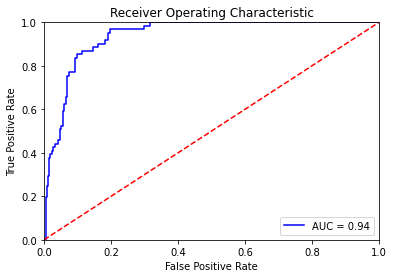

In [246]:

def data_prep_train(final_merge,test_ratio=0.2):
  train_features, test_features, train_labels, test_labels = train_test_split(final_merge, final_merge['Target'], stratify=final_merge['Target'],test_size = test_ratio, random_state = 42)
  print('Training Features Shape:', train_features.shape)
  print('Training Labels Shape:', train_labels.shape)
  print('Testing Features Shape:', test_features.shape)
  print('Testing Labels Shape:', test_labels.shape)

  #dropping some columns
  columns_to_drop_base_names=['FILE_TYPE','Close Price','Ticker','Target','Gains','Sub-Sector','Name','Market Cap','PE Ratio','Beta','Alpha']
  columns_to_drop_final=[]
  for items in columns_to_drop_base_names:
    if items !='Target' and items!='Gains':
      columns_to_drop_final.append(items+'_t')
      columns_to_drop_final.append(items+'_t_minus_1')
      #columns_to_drop_final.append(items+'_t_plus_1')
    else:
      print(items)
      columns_to_drop_final.append(items)

  columns_to_drop_final.append('Ticker_t_plus_1')
  columns_to_drop_final.append('Close Price_t_plus_1')


  for columns in columns_to_drop_final:
    if columns in train_features.columns:
      train_features.drop(columns=[columns],inplace=True)
      test_features.drop(columns=[columns],inplace=True)

  #now drop those features which have null values

  drop_list2=[]

  for columns in train_features.columns:
    if train_features[columns].isna().any():
      drop_list2.append(columns)

  train_features.drop(columns=drop_list2,inplace=True)
  test_features.drop(columns=drop_list2,inplace=True)

  return train_features, test_features, train_labels, test_labels

def normalize_train(train_features, test_features):
  mean_dict={}
  std_dict={}
  train_features_copy=train_features.copy(deep=True)
  test_features_copy=test_features.copy(deep=True)

  for cols in train_features_copy.columns:
    
    if '_trigger'  in cols or 'flag' in cols:
      #print('Not normalizing trigger/flags')
      continue
    
    mean_dict[cols]=train_features_copy[cols].mean() #for use while normalizing the test data
    std_dict[cols]=train_features_copy[cols].std() #for use while normalizing the test data
    
    mean=train_features_copy[cols].mean()
    std=train_features_copy[cols].std()

    train_features_copy[cols]=train_features_copy[cols]-mean
    train_features_copy[cols]=train_features_copy[cols]/std

    test_features_copy[cols]=test_features_copy[cols]-mean
    test_features_copy[cols]=test_features_copy[cols]/std
    
  
  return train_features_copy,test_features_copy,mean_dict,std_dict
  

#currently a logistic reg
def train_logit_model(train_features, test_features, train_labels, test_labels):
  print('Running logistic regression')
  log_reg = sm.Logit(train_labels, train_features,method='lbfgs',max_iter=50).fit() #bfgs
  print(log_reg.summary())
  write_path = 'logit_summary.csv'
  with open(write_path, 'w') as f:
    f.write(log_reg.summary().as_csv())
  
  yhat = log_reg.predict(train_features)
  yhat[yhat>0.5]=1
  yhat[yhat<=0.5]=0
  acc=(yhat == train_labels.values).sum()
  print('Train acc at 0.5',acc/len(train_labels)*100)

  yhat = log_reg.predict(test_features)
  yhat[yhat>0.5]=1
  yhat[yhat<=0.5]=0
  acc=(yhat == test_labels.values).sum()
  print('Test acc at 0.5',acc/len(test_labels)*100)

  tn, fp, fn, tp = confusion_matrix(test_labels, yhat).ravel()
  fpr=fp/(fp+tn)
  tpr=tp/(tp+fn)
  print('TPR ',tpr )
  print('FPR ',fpr)
  return log_reg

def plot_auc(log_reg,test_features,test_labels):
  preds = log_reg.predict(test_features)
  fpr, tpr, threshold = roc_curve(test_labels, preds)
  print(threshold.shape)
  roc_auc = auc(fpr, tpr)

  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  return 0


def train_rf_model(train_features, test_features, train_labels, test_labels):
  #Experimental
  print('Random forest')
  #log_reg = sm.Logit(train_labels, train_features,method='lbfgs',max_iter=50).fit() #bfgs
  #print(log_reg.summary())
  
  rf_model = RandomForestClassifier(random_state=0,n_estimators=150,max_features=int(0.3*len(train_features.columns)),min_samples_leaf=20)
  rf_model.fit(train_features,train_labels)
  #list_features=list(train_features.columns)


  yhat = rf_model.predict(train_features)
  print(np.unique(yhat))
  yhat[yhat>0.5]=1
  yhat[yhat<=0.5]=0
  acc=(yhat == train_labels.values).sum()
  print('Train acc ',acc/len(train_labels)*100)

  yhat = rf_model.predict(test_features)
  yhat[yhat>0.5]=1
  yhat[yhat<=0.5]=0
  acc=(yhat == test_labels.values).sum()
  print('Test acc at ',acc/len(test_labels)*100)

  tn, fp, fn, tp = confusion_matrix(test_labels, yhat).ravel()
  fpr=fp/(fp+tn)
  tpr=tp/(tp+fn)
  print('TPR ',tpr )
  print('FPR ',fpr)
  return rf_model  


def train_neural_net(train_features, test_features, train_labels, test_labels):
  #Experimental
  print('Neural net...')
  feature_length= len(train_features.columns)
  train_features_np=train_features.values
  train_labels_np=train_labels.values

  test_features_np=test_features.values
  test_labels_np=test_labels.values

  
  input=Input(shape=(feature_length,))
  hid1=Dense(int(0.7*feature_length),activation='relu')(input)
  hid2=Dense(int(0.5*feature_length),activation='relu')(hid1)
  hid3=Dense(int(0.25*feature_length),activation='relu')(hid2)
  hid4=Dense(int(0.25*feature_length),activation='relu')(hid3)
  output=Dense(1,activation='sigmoid')(hid4)
  model= Model(inputs=input,outputs=output)
  print(model.summary())
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  hist=model.fit(train_features_np,train_labels_np,shuffle=True,batch_size=16,epochs=20)

  
  yhat = model.predict(test_features_np)
  print(yhat.shape)
  yhat[yhat>0.5]=1
  yhat[yhat<=0.5]=0
  print(np.unique(yhat))
  print(np.unique(test_labels_np))
  test_labels_np_expanded=np.expand_dims(test_labels_np,axis=-1)
  #acc= (yhat == test_labels_np).sum()
  #print(acc.shape)
  print(yhat.shape)
  print(test_labels_np.shape)
  #print(len(test_labels))
  #print('Test acc at 0.5 ',acc/len(test_labels))

  tn, fp, fn, tp = confusion_matrix(test_labels, yhat).ravel()
  fpr=fp/(fp+tn)
  tpr=tp/(tp+fn)
  print('TPR ',tpr )
  print('FPR ',fpr)
  
  return model


def train_xgboost(train_features, test_features, train_labels, test_labels):
  #Experimental
  param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}
  
  print('XGboost')
  xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

  xgb_cl.fit(train_features,train_labels)
  yhat = xgb_cl.predict(train_features)
  print(np.unique(yhat))
  yhat[yhat>0.5]=1
  yhat[yhat<=0.5]=0
  acc=(yhat == train_labels.values).sum()
  print('Train acc ',acc/len(train_labels)*100)

  yhat = xgb_cl.predict_proba(test_features)
  #print(yhat)
  yhat=yhat[:,1]
  yhat[yhat>0.5]=1
  yhat[yhat<=0.5]=0
  acc=(yhat == test_labels.values).sum()
  print('Test acc at ',acc/len(test_labels)*100)

  tn, fp, fn, tp = confusion_matrix(test_labels, yhat).ravel()
  fpr=fp/(fp+tn)
  tpr=tp/(tp+fn)
  print('TPR ',tpr )
  print('FPR ',fpr)
  return xgb_cl 

def plot_feature_importance(model,feature_list):
  importances=model.feature_importances_
  
  # Set the style
  #plt.style.use('fivethirtyeight')
  # list of x locations for plotting
  x_values = list(range(len(importances)))
  # Make a bar chart
  plt.bar(x_values, importances, orientation = 'vertical')
  # Tick labels for x axis
  plt.xticks(x_values, feature_list, rotation='vertical')
  # Axis labels and title
  plt.ylabel('Importance')
  plt.xlabel('Variable') 
  plt.title('Variable Importances')
  return 0

train_features, test_features, train_labels, test_labels=data_prep_train(final_merge=final_merge,test_ratio=0.2)
train_features_norm,test_features_norm,mean_dict,std_dict=normalize_train(train_features,test_features)


if model_name=='logit':
  print('Running logistic regression')
  if norm:
    print('Normalizing')
    model=train_logit_model(train_features_norm, test_features_norm, train_labels, test_labels)
    plot_auc(model,test_features_norm,test_labels)
  else:
    model=train_logit_model(train_features, test_features, train_labels, test_labels)
    plot_auc(model,test_features,test_labels)
elif model_name=='random_forest':
  print('Running random forest')
  model=train_rf_model(train_features, test_features, train_labels, test_labels)
  #plot_auc(model,test_features,test_labels)
elif model_name=='neural_net':
  print('Running neural net')

  if norm:
    model=train_neural_net(train_features_norm, test_features_norm, train_labels, test_labels)
    #since keras model requires numpy arrays and not dataframe
    plot_auc(model,test_features_norm.values,test_labels)
  else:
    model=train_neural_net(train_features, test_features, train_labels, test_labels)
    plot_auc(model,test_features.values,test_labels)

elif model_name=='xgboost':
  print('Running xgboost')
  if norm:
    print('Normalized')
    model=train_xgboost(train_features_norm, test_features_norm, train_labels, test_labels)
    plot_auc(model,test_features_norm,test_labels)
  else:
    model=train_xgboost(train_features, test_features, train_labels, test_labels)
    plot_auc(model,test_features,test_labels)

In [247]:
if model_name=='random_forest' or model_name=='xgboost':
  plot_feature_importance(model,list(train_features.columns))
  print('Done')

In [248]:
def data_prep_test(final_merge,test_ratio=0.2):

  #dropping some columns
  columns_to_drop_base_names=['FILE_TYPE','Close Price','Ticker','Target','Gains','Sub-Sector','Name','Market Cap','PE Ratio','Beta','Alpha']
  columns_to_drop_final=[]
  labels=final_merge['Target']
  stock_pkey_df=final_merge[['Ticker_t','Gains','Target']] #so that we can consume the prediction and make stock picks
  
  #in addition to this drop columns having null values ...ie whose missing values have not been imputed
  #removing both t and t-1 columns
  for items in columns_to_drop_base_names:
    if items !='Target' and items!='Gains':
      columns_to_drop_final.append(items+'_t')
      columns_to_drop_final.append(items+'_t_minus_1')
      #columns_to_drop_final.append(items+'_t_plus_1')
    else:
      print(items)
      columns_to_drop_final.append(items)

  columns_to_drop_final.append('Ticker_t_plus_1')
  columns_to_drop_final.append('Close Price_t_plus_1')


  for columns in columns_to_drop_final:
    if columns in final_merge.columns:
      final_merge.drop(columns=[columns],inplace=True)
      

  #now drop those features which have null values

  drop_list2=[]

  for columns in final_merge.columns:
    if final_merge[columns].isna().any():
      drop_list2.append(columns)

  final_merge.drop(columns=drop_list2,inplace=True)
  
  #final_merge has only model independent variables
  return final_merge,labels,stock_pkey_df



def get_test_acc(log_reg,X,y,thresh=0.5):
  pred=log_reg.predict(X)
  #print(pred)
  pred_proba=np.array(pred) #crating a copy
  pred[pred>thresh]=1
  pred[pred<=thresh]=0
  #acc=(y==pred).sum()
  #print(f'Test acc at {thresh}',acc/len(y)*100)
  tn, fp, fn, tp = confusion_matrix(y, pred).ravel()

  fpr=fp/(fp+tn)
  tpr=tp/(tp+fn)
  print(f'TPR at {thresh} {tpr}')
  print(f'FPR at {thresh} {fpr}')
  return pred,pred_proba

def norm_test_set(X,mean_dict,std_dict):
  print('Normalizing test set')
  for keys in mean_dict.keys():
    X[keys]=X[keys]-mean_dict[keys]
    X[keys]=X[keys]/std_dict[keys]
    print(type(std_dict[keys]))
  return X


In [249]:
# import os
# os.listdir('drive/ticker_tape_data/')

drive/ticker_tape_data/Technicals_only_12_10_2021.csv
drive/ticker_tape_data/Technicals_only_12_9_2021.csv
Dropped duplicates
Dropped duplicates
Dropped duplicates
RSI Exponential – 14D
flag1  [1 0]
flag2  [0 1]
RSI – 14D
flag1  [0 1]
flag2  [0 1]
Stochastic %D
flag1  [1 0]
flag2  [0 1]
Stochastic %K
flag1  [1 0]
flag2  [0 1]
William so neg range
William %R
flag1  [1 0]
flag2  [0 1]
ADX Rating – Trend Strength
flag1  [0 1]
flag2  [0 1]
RSI Exponential – 14D
flag1  [0 1]
flag2  [0 1]
RSI – 14D
flag1  [0 1]
flag2  [0 1]
Stochastic %D
flag1  [0 1]
flag2  [0 1]
Stochastic %K
flag1  [1 0]
flag2  [0 1]
William so neg range
William %R
flag1  [1 0]
flag2  [0 1]
ADX Rating – Trend Strength
flag1  [0 1]
flag2  [0 1]
About to rename columns
MACD Line 2 – Signal Line Comp 0
MACD Line 2 – Signal Line Comp 0
MACD Line 1 – Trend Indicator 0
MACD Line 1 – Trend Indicator 0
ADX_above_25 0
ADX_above_25 0
% From Parabolic SAR 0
% From Parabolic SAR 0
% From Upper Bollinger Band 0
% From Upper Bollinger B

/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


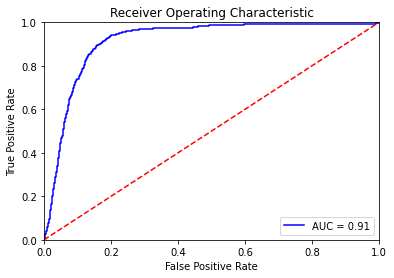

In [250]:

#------Testing mode on a diff time period starts---------#

t_minus_1 = '12_9_2021'
t='12_10_2021'
t_plus_1='12_11_2021'

df_t,df_t_minus_1,df_t_plus_1,rename_t_plus_1=read_technical_df(t,t_minus_1,t_plus_1)

processed_df_tech_t,final_column_list=process_technicals(df_t)
processed_df_tech_t_minus_1,final_column_list=process_technicals(df_t_minus_1)

final_merge,rename_t,rename_t_minus_1=interday_technicals(processed_df_tech_t,processed_df_tech_t_minus_1,'t','t_minus_1')

#-------------------------------------------------------------------------#

#final_column_list.append('diff_KD')
for columns in final_column_list:
  if 'flag' in columns:
    final_merge=create_trigger(final_merge,rename_t_minus_1,rename_t,columns,col_type='flag') #
  else:
    final_merge=difference_KPI(final_merge,rename_t_minus_1,rename_t,columns)


column_to_be_selected=[]

for columns in final_merge:
  if columns.endswith('_difference') or columns.endswith('_trigger') or '_trigger_' in columns or 'flag'  in columns:
    column_to_be_selected.append(columns)

column_to_be_selected.append(rename_t['Ticker']) #as a key to join dataframes
column_to_be_selected.append(rename_t['Close Price'])
column_to_be_selected.append(rename_t_minus_1['Close Price']) 
final_merge=final_merge[column_to_be_selected]




#-----------------------------------------------------------------------#
final_merge=create_target(final_merge,df_t_plus_1,rename_t,rename_t_plus_1,gain_perc=gain_perc)
for items in final_merge.columns:
  print(items)

  
final_merge=final_merge[columns_after_corr_removal]

test_features,test_labels,stock_pkey_df=data_prep_test(final_merge)

if (norm and model_name=='logit') or (norm and model_name=='neural_net') or (norm and model_name=='xgboost'):
  print('Normalization used')
  test_features=norm_test_set(test_features,mean_dict,std_dict)


if model_name=='logit':  
  preds,pred_proba=get_test_acc(model,X=test_features,y=test_labels,thresh=0.5)
  plot_auc(model,test_features,test_labels)
elif model_name=='neural_net':
  preds,pred_proba=get_test_acc(model,X=test_features.values,y=test_labels,thresh=0.5)
  plot_auc(model,test_features.values,test_labels)
elif model_name=='random_forest':
  preds,pred_proba=get_test_acc(model,X=test_features,y=test_labels,thresh=0.5)
elif model_name=='xgboost':
  preds,pred_proba=get_test_acc(model,X=test_features,y=test_labels,thresh=0.5)
  plot_auc(model,test_features,test_labels)


In [251]:
stock_pkey_df['preds']=preds.tolist()
stock_pkey_df['preds_proba']=pred_proba.tolist()

stock_pkey_df.to_csv('final_predictions_stock_data.csv',index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [241]:
stock_pkey_df

,Ticker_t,Gains,Target,preds,preds_proba
0,RELIANCE,1.008439,0,0.0,0.089486
1,TCS,1.001399,0,0.0,0.032901
2,HDFCBANK,0.989920,0,0.0,0.009888
3,INFY,1.001689,0,0.0,0.056232
4,HINDUNILVR,0.998333,0,0.0,0.029881
...,...,...,...,...,...
3261,YUG,1.000000,0,0.0,0.056479
3262,TIMESGREEN,1.000000,0,0.0,0.011575
3263,GENESIS,1.000000,0,0.0,0.056369
3264,PALCO,1.000000,0,0.0,0.132306
